In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from utils import fix_labels, evaluate_masks, visualize_overlay
from sklearn.metrics import accuracy_score, jaccard_score, f1_score
from dataset import ISICDataset
from PIL import Image

# Paths
image_dir = "./data/images"
mask_dir = "./data/masks"
split_file = "./splits/test.txt"

# model = KMeans(n_clusters=2, random_state=0)
model = GaussianMixture(n_components=2, random_state=0)

# Load test split
with open(split_file, "r") as f:
    image_names = [line.strip() for line in f.readlines()]

# Predict masks for each image
pred_masks = []
gt_masks = []
images = []

for name in image_names:
    img_path = os.path.join(image_dir, name)
    mask_path = os.path.join(mask_dir, name.replace(".jpg", "_segmentation.png"))

    image = Image.open(img_path).convert("RGB").resize((128, 128))
    image_np = np.array(image)
    mask = Image.open(mask_path).convert("L").resize((128, 128))
    mask_np = (np.array(mask) > 0).astype(np.uint8)

    h, w, _ = image_np.shape
    pixels = image_np.reshape((-1, 3)) / 255.0
    model.fit(pixels)

    if isinstance(model, KMeans):
        segmented = model.labels_.reshape((h, w))
    else:
        segmented = model.predict(pixels).reshape((h, w))

    pred_masks.append(segmented.astype(np.uint8))
    gt_masks.append(mask_np)
    images.append(image_np)

In [2]:
# Align predicted labels with GT
pred_masks = fix_labels(pred_masks, gt_masks)

acc_list, iou_list, f1_list = [], [], []

for i, (pred, gt) in enumerate(zip(pred_masks, gt_masks)):
    pred_flat = pred.flatten()
    gt_flat = gt.flatten()

    acc = accuracy_score(gt_flat, pred_flat)
    iou = jaccard_score(gt_flat, pred_flat)
    f1 = f1_score(gt_flat, pred_flat)

    acc_list.append(acc)
    iou_list.append(iou)
    f1_list.append(f1)

    # print(f"[{i:02d}] Acc: {acc:.3f} | IoU: {iou:.3f} | F1: {f1:.3f}")


🔴 Worst Predictions


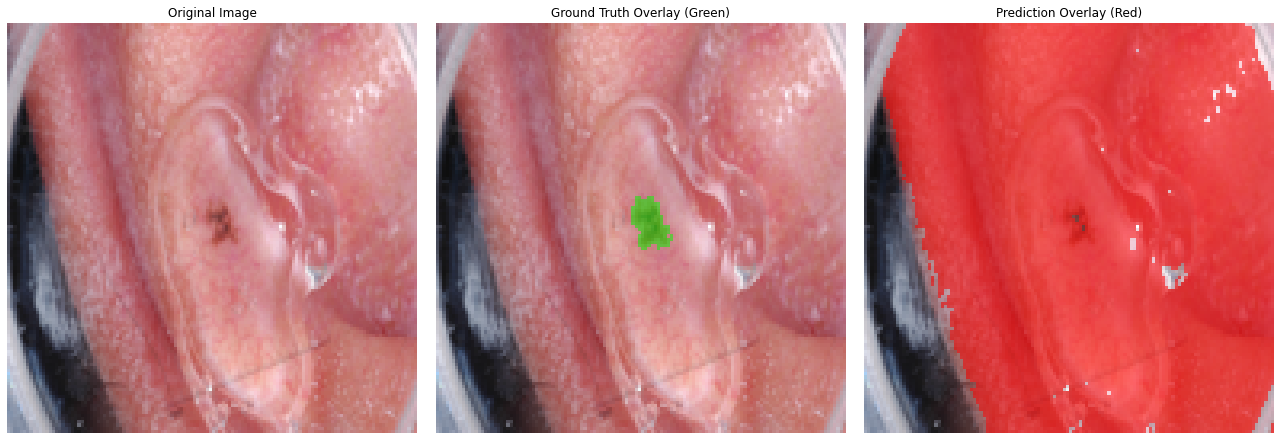

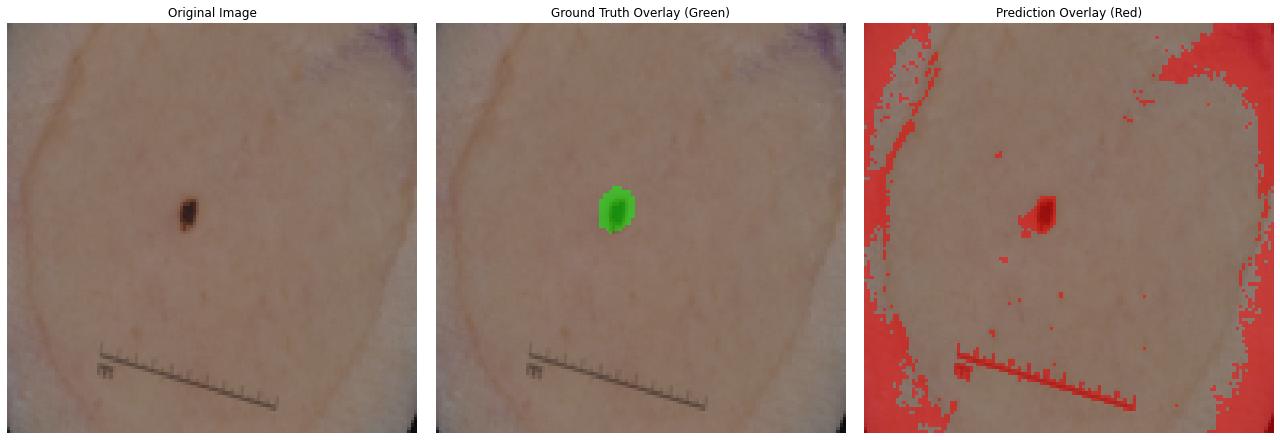

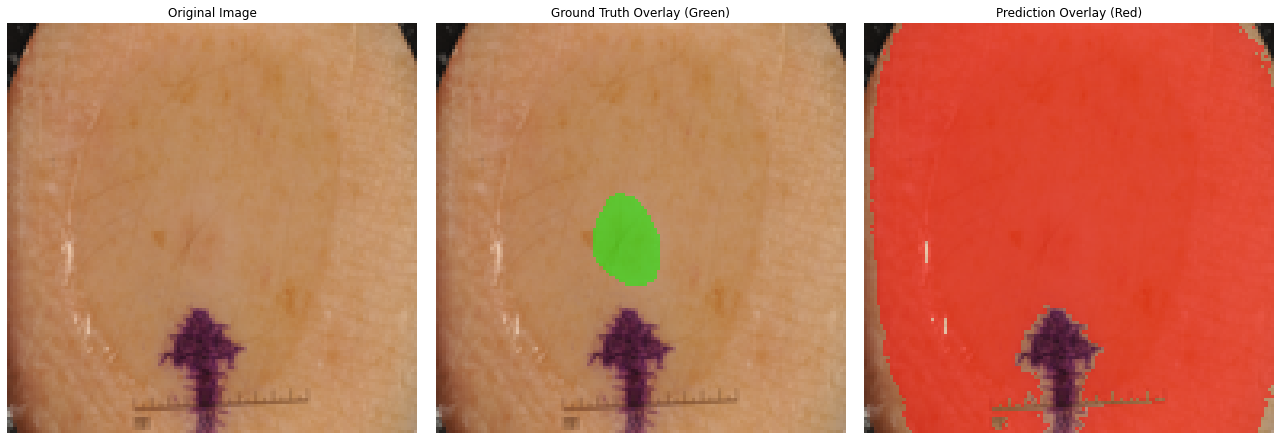


🟢 Best Predictions


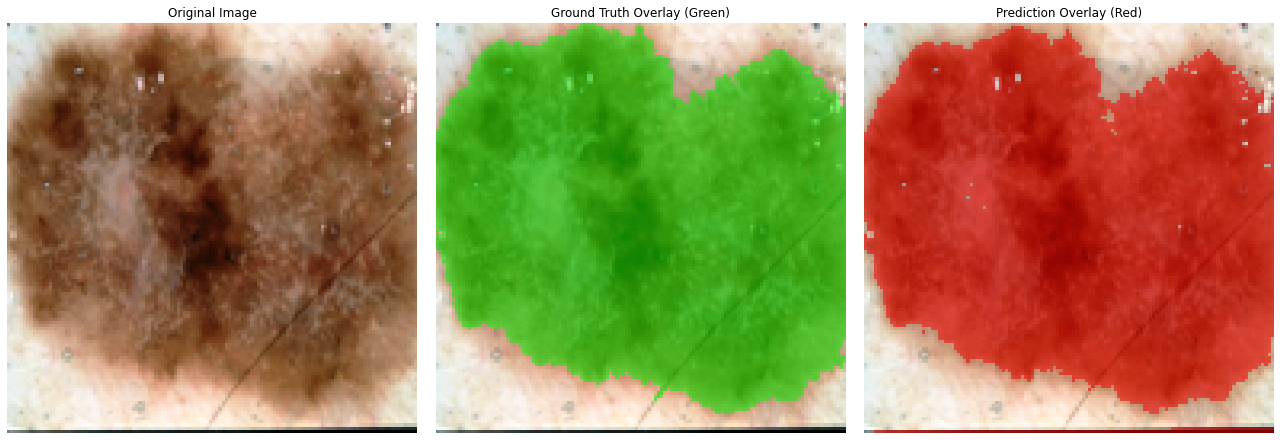

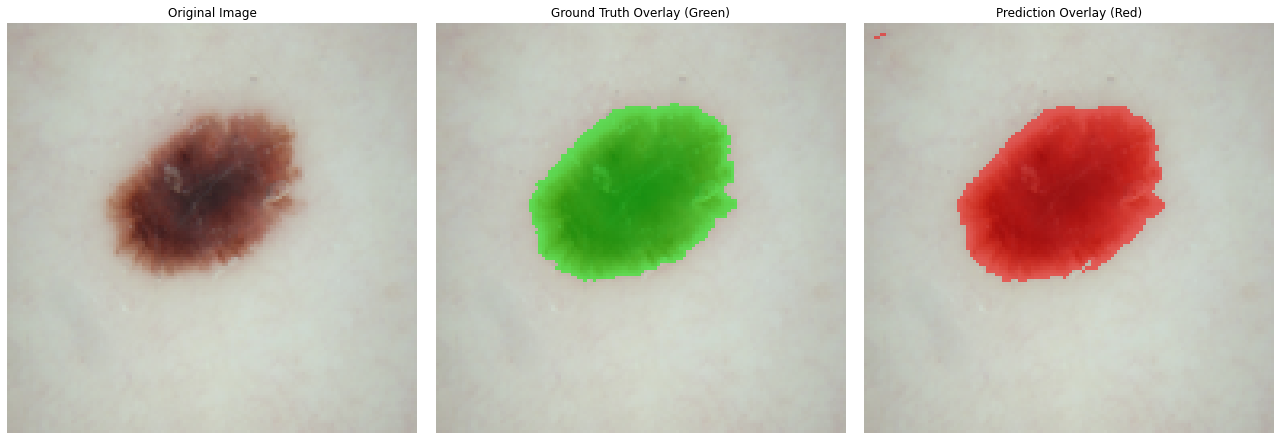

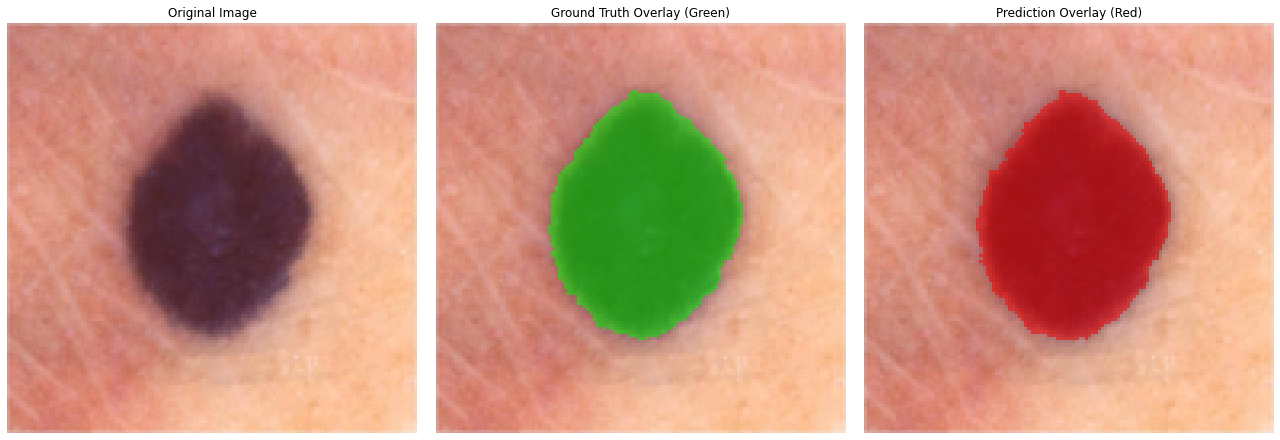

In [3]:
sorted_indices = np.argsort(f1_list)

print("\n🔴 Worst Predictions")
for i in sorted_indices[:3]:
    visualize_overlay(images[i], gt_masks[i], pred_masks[i])

print("\n🟢 Best Predictions")
for i in sorted_indices[-3:]:
    visualize_overlay(images[i], gt_masks[i], pred_masks[i])

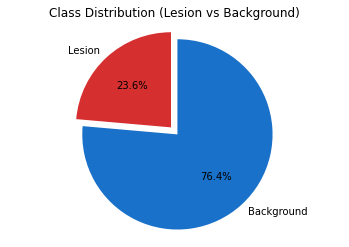

In [15]:
# Assuming `gt_masks` is a list of ground truth masks you've already loaded
def compute_class_distribution(gt_masks):
    lesion_pixels = 0
    background_pixels = 0

    for mask in gt_masks:
        lesion_pixels += np.sum(mask)  # Assuming lesion is 1 and background is 0
        background_pixels += np.sum(1 - mask)

    total_pixels = lesion_pixels + background_pixels
    lesion_ratio = lesion_pixels / total_pixels
    background_ratio = background_pixels / total_pixels

    return lesion_ratio, background_ratio


# Compute the distribution
lesion_ratio, background_ratio = compute_class_distribution(gt_masks)

# Visualize the distribution
labels = ["Lesion", "Background"]
sizes = [lesion_ratio, background_ratio]
colors = ["#d62f2f", "#1a71c9"]
explode = (0.1, 0)  # explode the 1st slice

plt.figure(figsize=(6, 4))
plt.pie(
    sizes,
    explode=explode,
    labels=labels,
    colors=colors,
    autopct="%1.1f%%",
    startangle=90,
)
plt.axis("equal")  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title("Class Distribution (Lesion vs Background)")
plt.show()

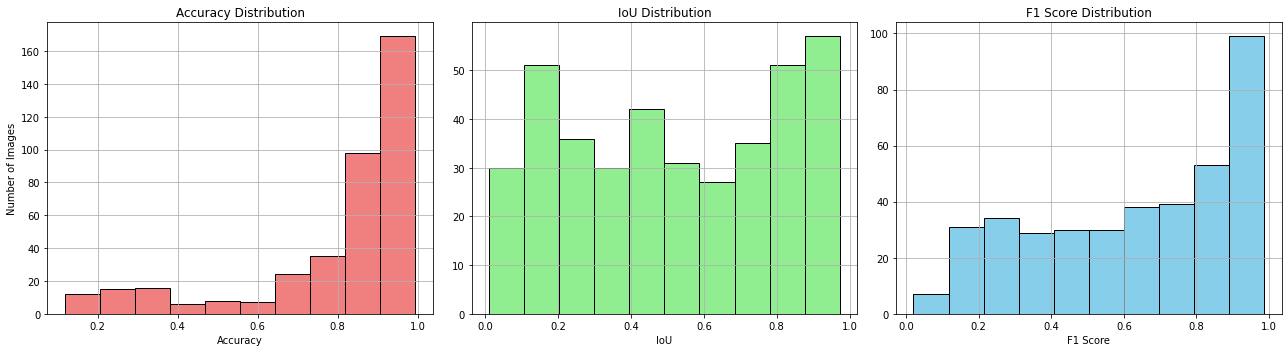

In [4]:
# Plot Accuracy, IoU, and F1 Score distributions
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

axs[0].hist(acc_list, bins=10, color="lightcoral", edgecolor="black")
axs[0].set_title("Accuracy Distribution")
axs[0].set_xlabel("Accuracy")
axs[0].set_ylabel("Number of Images")
axs[0].grid(True)

axs[1].hist(iou_list, bins=10, color="lightgreen", edgecolor="black")
axs[1].set_title("IoU Distribution")
axs[1].set_xlabel("IoU")
axs[1].grid(True)

axs[2].hist(f1_list, bins=10, color="skyblue", edgecolor="black")
axs[2].set_title("F1 Score Distribution")
axs[2].set_xlabel("F1 Score")
axs[2].grid(True)

plt.tight_layout()
plt.show()